<a href="https://colab.research.google.com/github/Darius888/AI_game_project/blob/master/CycleGan_Base_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 30.2 MB/s 


In [3]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
%cd /content/drive/MyDrive/Kaggle_Monet/

/content/drive/MyDrive/Kaggle_Monet


In [5]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/kaggle"

In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import os, random, json, PIL, shutil, re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow_addons as tfa
from tensorflow.keras import Model, losses, optimizers

import matplotlib.pyplot as plt
import numpy as np

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

Number of replicas: 1
2.9.2


In [7]:
GCS_PATH = '/content/drive/MyDrive/Kaggle_Monet/gan-getting-started'

MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

n_monet_samples = count_data_items(MONET_FILENAMES)
n_photo_samples = count_data_items(PHOTO_FILENAMES)

print(f'Monet TFRecord files: {len(MONET_FILENAMES)}')
print(f'Monet image files: {n_monet_samples}')
print(f'Photo TFRecord files: {len(PHOTO_FILENAMES)}')
print(f'Photo image files: {n_photo_samples}')


Monet TFRecord Files: 5
Photo TFRecord Files: 20
Monet TFRecord files: 5
Monet image files: 300
Photo TFRecord files: 20
Photo image files: 7038


In [8]:
HEIGHT = 256
WIDTH = 256
CHANNELS = 3
EPOCHS = 50
BATCH_SIZE = 1

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=CHANNELS)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [HEIGHT, WIDTH, CHANNELS])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        'image_name': tf.io.FixedLenFeature([], tf.string),
        'image':      tf.io.FixedLenFeature([], tf.string),
        'target':     tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

def load_dataset(filenames):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

def get_gan_dataset(monet_files, photo_files, augment=None, repeat=True, shuffle=True, batch_size=1):

    monet_ds = load_dataset(monet_files)
    photo_ds = load_dataset(photo_files)

    if repeat:
        monet_ds = monet_ds.repeat()
        photo_ds = photo_ds.repeat()
    if shuffle:
        monet_ds = monet_ds.shuffle(2048)
        photo_ds = photo_ds.shuffle(2048)
        
    monet_ds = monet_ds.batch(batch_size, drop_remainder=True)
    photo_ds = photo_ds.batch(batch_size, drop_remainder=True)
    monet_ds = monet_ds.cache()
    photo_ds = photo_ds.cache()
    monet_ds = monet_ds.prefetch(AUTOTUNE)
    photo_ds = photo_ds.prefetch(AUTOTUNE)
    
    gan_ds = tf.data.Dataset.zip((monet_ds, photo_ds))
    
    return gan_ds

def display_samples(ds, row, col):
    ds_iter = iter(ds)
    plt.figure(figsize=(15, int(15*row/col)))
    for j in range(row*col):
        example_sample = next(ds_iter)
        plt.subplot(row,col,j+1)
        plt.axis('off')
        plt.imshow(example_sample[0] * 0.5 + 0.5)
    plt.show()
        
def display_generated_samples(ds, model, n_samples):
    ds_iter = iter(ds)
    for n_sample in range(n_samples):
        example_sample = next(ds_iter)
        generated_sample = model.predict(example_sample)
        
        plt.subplot(121)
        plt.title("input image")
        plt.imshow(example_sample[0] * 0.5 + 0.5)
        plt.axis('off')
        
        plt.subplot(122)
        plt.title("Generated image")
        plt.imshow(generated_sample[0] * 0.5 + 0.5)
        plt.axis('off')
        plt.show()
        
def predict_and_save(input_ds, generator_model, output_path):
    i = 1
    for img in input_ds:
        prediction = generator_model(img, training=False)[0].numpy() # make predition
        prediction = (prediction * 127.5 + 127.5).astype(np.uint8)   # re-scale
        im = PIL.Image.fromarray(prediction)
        im.save(f'{output_path}{str(i)}.jpg')
        i += 1
                

# Model functions
def downsample(filters, size, apply_instancenorm=True, strides=2):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = tf.keras.Sequential()
    result.add(L.Conv2D(filters, size, strides=strides, padding='same',
                        kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    result.add(L.LeakyReLU())

    return result

def upsample(filters, size, apply_dropout=False, strides=2):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = tf.keras.Sequential()
    result.add(L.Conv2DTranspose(filters, size, strides=strides, padding='same',
                                 kernel_initializer=initializer, use_bias=False))

    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(L.Dropout(0.5))

    result.add(L.ReLU())

    return result

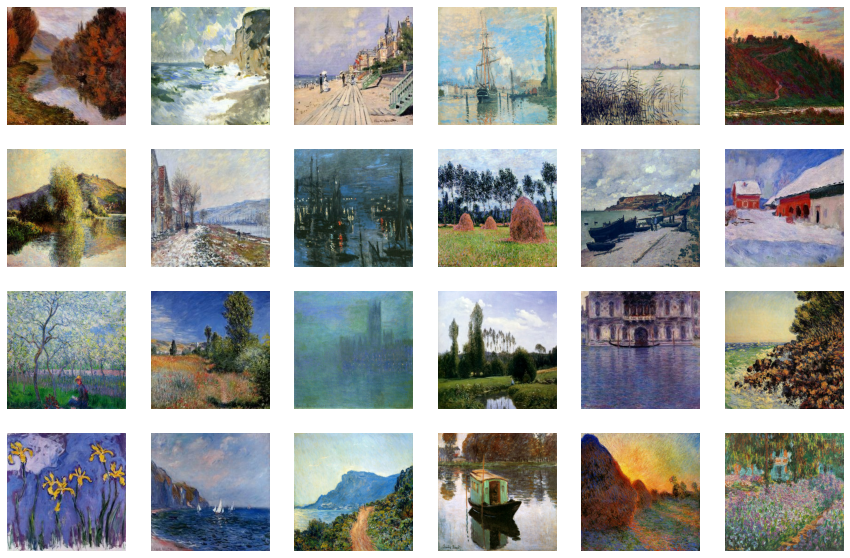

In [9]:
display_samples(load_dataset(MONET_FILENAMES).batch(1), 4, 6)

In [11]:
fast_photo_ds = load_dataset(PHOTO_FILENAMES).batch(32*strategy.num_replicas_in_sync).prefetch(32)
fid_photo_ds = load_dataset(PHOTO_FILENAMES).take(1024).batch(32*strategy.num_replicas_in_sync).prefetch(32)
fid_monet_ds = load_dataset(MONET_FILENAMES).batch(32*strategy.num_replicas_in_sync).prefetch(32)


In [12]:
with strategy.scope():

    inception_model = tf.keras.applications.InceptionV3(input_shape=(256,256,3),pooling="avg",include_top=False)

    mix3  = inception_model.get_layer("mixed9").output
    f0 = tf.keras.layers.GlobalAveragePooling2D()(mix3)

    inception_model = tf.keras.Model(inputs=inception_model.input, outputs=f0)
    inception_model.trainable = False

    
    
    def calculate_activation_statistics_mod(images,fid_model):

            act=tf.cast(fid_model.predict(images), tf.float32)

            mu = tf.reduce_mean(act, axis=0)
            mean_x = tf.reduce_mean(act, axis=0, keepdims=True)
            mx = tf.matmul(tf.transpose(mean_x), mean_x)
            vx = tf.matmul(tf.transpose(act), act)/tf.cast(tf.shape(act)[0], tf.float32)
            sigma = vx - mx
            return mu, sigma
    myFID_mu2, myFID_sigma2 = calculate_activation_statistics_mod(fid_monet_ds,inception_model)        
    fids=[]

with strategy.scope():
    def calculate_frechet_distance(mu1,sigma1,mu2,sigma2):
        fid_epsilon = 1e-14
       
        covmean = tf.linalg.sqrtm(tf.cast(tf.matmul(sigma1,sigma2),tf.complex64))
#         isgood=tf.cast(tf.math.is_finite(covmean), tf.int32)
#         if tf.size(isgood)!=tf.math.reduce_sum(isgood):
#             return 0

        covmean = tf.cast(tf.math.real(covmean),tf.float32)
  
        tr_covmean = tf.linalg.trace(covmean)


        return tf.matmul(tf.expand_dims(mu1 - mu2, axis=0),tf.expand_dims(mu1 - mu2, axis=1)) + tf.linalg.trace(sigma1) + tf.linalg.trace(sigma2) - 2 * tr_covmean


    
    
    def FID(images,gen_model,inception_model=inception_model,myFID_mu2=myFID_mu2, myFID_sigma2=myFID_sigma2):
                inp = layers.Input(shape=[256, 256, 3], name='input_image')
                x  = gen_model(inp)
                x=inception_model(x)
                fid_model = tf.keras.Model(inputs=inp, outputs=x)
                
                mu1, sigma1= calculate_activation_statistics_mod(images,fid_model)

                fid_value = calculate_frechet_distance(mu1, sigma1,myFID_mu2, myFID_sigma2)


                return fid_value

10/10 [==============================] - 9s 51ms/step


In [19]:
OUTPUT_CHANNELS = 3

def generator_fn():
    inputs = L.Input(shape=[HEIGHT, WIDTH, CHANNELS])

    down_stack = [
        downsample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
        downsample(128, 4),                          # (bs, 64, 64, 128)
        downsample(256, 4),                          # (bs, 32, 32, 256)
        downsample(512, 4),                          # (bs, 16, 16, 512)
        downsample(512, 4),                          # (bs, 8, 8, 512)
        downsample(512, 4),                          # (bs, 4, 4, 512)
        downsample(512, 4),                          # (bs, 2, 2, 512)
        downsample(512, 4),                          # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4),                     # (bs, 16, 16, 1024)
        upsample(256, 4),                     # (bs, 32, 32, 512)
        upsample(128, 4),                     # (bs, 64, 64, 256)
        upsample(64, 4),                      # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = L.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                             strides=2,
                             padding='same',
                             kernel_initializer=initializer,
                             activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = L.Concatenate()([x, skip])

    x = last(x)

    return Model(inputs=inputs, outputs=x)

In [20]:
def discriminator_fn():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = L.Input(shape=[HEIGHT, WIDTH, CHANNELS], name='input_image')

    x = inp

    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = L.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = L.Conv2D(512, 4, strides=1,
                    kernel_initializer=initializer,
                    use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)

    leaky_relu = L.LeakyReLU()(norm1)

    zero_pad2 = L.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = L.Conv2D(1, 4, strides=1,
                    kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return Model(inputs=inp, outputs=last)

In [25]:
with strategy.scope():
    monet_generator = generator_fn() # transforms photos to Monet-esque paintings
    photo_generator = generator_fn() # transforms Monet paintings to be more like photos

    monet_discriminator = discriminator_fn() # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = discriminator_fn() # differentiates real photos and generated photos


class CycleGan(Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        # self.build((None,) + (HEIGHT, WIDTH))
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            'monet_gen_loss': total_monet_gen_loss,
            'photo_gen_loss': total_photo_gen_loss,
            'monet_disc_loss': monet_disc_loss,
            'photo_disc_loss': photo_disc_loss
        }

In [26]:
with strategy.scope():
    # Discriminator loss {0: fake, 1: real} (The discriminator loss outputs the average of the real and generated loss)
    def discriminator_loss(real, generated):
        real_loss = losses.BinaryCrossentropy(from_logits=True, reduction=losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = losses.BinaryCrossentropy(from_logits=True, reduction=losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5
    
    # Generator loss
    def generator_loss(generated):
        return losses.BinaryCrossentropy(from_logits=True, reduction=losses.Reduction.NONE)(tf.ones_like(generated), generated)
    
    
    # Cycle consistency loss (measures if original photo and the twice transformed photo to be similar to one another)
    with strategy.scope():
        def calc_cycle_loss(real_image, cycled_image, LAMBDA):
            loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

            return LAMBDA * loss1

    # Identity loss (compares the image with its generator (i.e. photo with photo generator))
    with strategy.scope():
        def identity_loss(real_image, same_image, LAMBDA):
            loss = tf.reduce_mean(tf.abs(real_image - same_image))
            return LAMBDA * 0.5 * loss

In [27]:
with strategy.scope():
    # Create generators
    monet_generator_optimizer = optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = optimizers.Adam(2e-4, beta_1=0.5)

    # Create discriminators
    monet_discriminator_optimizer = optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = optimizers.Adam(2e-4, beta_1=0.5)
    
    # Create GAN
    gan_model = CycleGan(monet_generator, photo_generator, monet_discriminator, photo_discriminator)

    gan_model.compile(m_gen_optimizer=monet_generator_optimizer,
                      p_gen_optimizer=photo_generator_optimizer,
                      m_disc_optimizer=monet_discriminator_optimizer,
                      p_disc_optimizer=photo_discriminator_optimizer,
                      gen_loss_fn=generator_loss,
                      disc_loss_fn=discriminator_loss,
                      cycle_loss_fn=calc_cycle_loss,
                      identity_loss_fn=identity_loss)
    

history = gan_model.fit(get_gan_dataset(MONET_FILENAMES, PHOTO_FILENAMES, batch_size=BATCH_SIZE), 
                        steps_per_epoch=(n_monet_samples//BATCH_SIZE),
                        epochs=20,
                        verbose=2).history
FID(fid_photo_ds,monet_generator) 

Epoch 1/20
300/300 - 60s - monet_gen_loss: 3.0741 - photo_gen_loss: 3.4620 - monet_disc_loss: 0.7937 - photo_disc_loss: 0.5928 - 60s/epoch - 200ms/step
Epoch 2/20
300/300 - 24s - monet_gen_loss: 4.1097 - photo_gen_loss: 4.2688 - monet_disc_loss: 0.8541 - photo_disc_loss: 0.6077 - 24s/epoch - 79ms/step
Epoch 3/20
300/300 - 24s - monet_gen_loss: 2.7085 - photo_gen_loss: 3.3951 - monet_disc_loss: 0.5907 - photo_disc_loss: 0.3923 - 24s/epoch - 78ms/step
Epoch 4/20
300/300 - 23s - monet_gen_loss: 3.1723 - photo_gen_loss: 3.8574 - monet_disc_loss: 0.4379 - photo_disc_loss: 0.3792 - 23s/epoch - 78ms/step
Epoch 5/20
300/300 - 23s - monet_gen_loss: 3.4644 - photo_gen_loss: 3.9093 - monet_disc_loss: 0.5520 - photo_disc_loss: 0.5204 - 23s/epoch - 78ms/step
Epoch 6/20
300/300 - 24s - monet_gen_loss: 4.0949 - photo_gen_loss: 2.6250 - monet_disc_loss: 0.7972 - photo_disc_loss: 0.7542 - 24s/epoch - 79ms/step
Epoch 7/20
300/300 - 24s - monet_gen_loss: 3.7124 - photo_gen_loss: 3.5570 - monet_disc_loss:

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[16.549526]], dtype=float32)>

In [29]:
val = FID(fid_photo_ds,monet_generator)

32/32 [==============================] - 3s 35ms/step


In [ ]:
tf.saved_model.save(gan_model, "/content/drive/MyDrive/Applied_Deep_Learning/models/test_model/")

In [ ]:
 model_loaded = tf.saved_model.load("/content/drive/MyDrive/Applied_Deep_Learning/models/test_model/")

1/1 [==============================] - 1s 697ms/step


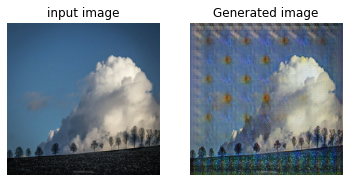

1/1 [==============================] - 0s 20ms/step


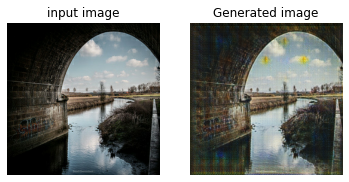

1/1 [==============================] - 0s 21ms/step


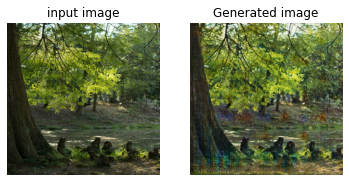

1/1 [==============================] - 0s 21ms/step


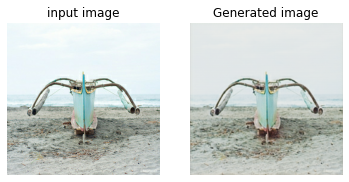

1/1 [==============================] - 0s 20ms/step


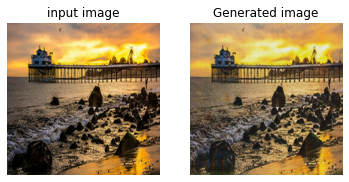

1/1 [==============================] - 0s 20ms/step


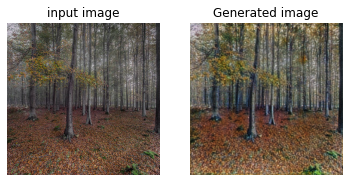

1/1 [==============================] - 0s 21ms/step


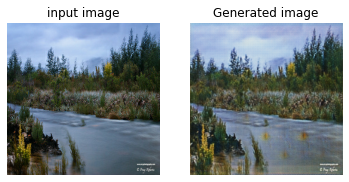

1/1 [==============================] - 0s 20ms/step


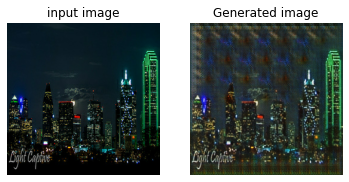

In [ ]:
display_generated_samples(load_dataset(PHOTO_FILENAMES).batch(1), monet_generator, 8)


In [ ]:
os.makedirs('../images/') # Create folder to save generated images

predict_and_save(load_dataset(PHOTO_FILENAMES).batch(1), monet_generator, '../images/')

In [ ]:
shutil.make_archive('/kaggle/working/images/', 'zip', '../images')

print(f"Generated samples: {len([name for name in os.listdir('../images/') if os.path.isfile(os.path.join('../images/', name))])}")